In [18]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from tqdm import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import sys
sys.path.append("../")

In [20]:
import torch
from torch import nn

from models.embedding import SphericalGraphCNN

In [21]:
from utils import create_mask as cm
from simulations.wrapper import simulator
from models.scd import dnds
from utils.psf_correction import PSFCorrection
from models.psf import KingPSF
from utils.templates import get_NFW2_template
from sbi import utils
from operator import itemgetter

## Test embedding net

In [22]:
r_outer = 25

In [23]:
nside_list = [128, 64, 32, 16, 8, 4, 2]

In [24]:
hp_mask_nside1 = cm.make_mask_total(nside=1, band_mask = True, band_mask_range = 0,
                              mask_ring = True, inner = 0, outer = r_outer)

indexes_list = []
masks_list = []
for nside in nside_list:
    hp_mask = hp.ud_grade(hp_mask_nside1, nside)
    masks_list.append(hp_mask)
    indexes_list.append(np.arange(hp.nside2npix(nside))[~hp_mask])

In [25]:
ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")

In [26]:
kp = KingPSF()

pc_inst = PSFCorrection(delay_compute=True)
pc_inst.psf_r_func = lambda r: kp.psf_fermi_r(r)

In [27]:
# Load templates

fermi_exp = np.load("../data/fermi_data/fermidata_exposure.npy")

roi_normalize_temps = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=30)

# temp_gce = np.load("../data/fermi_data/template_gce.npy")
temp_gce = get_NFW2_template(gamma=1.2, exp_map=fermi_exp, roi_normalize=roi_normalize_temps)
temp_dif = np.load("../data/fermi_data/template_dif.npy")
temp_psc = np.load("../data/fermi_data/template_psc.npy")
temp_iso = np.load("../data/fermi_data/template_iso.npy")
temp_dsk_thk = np.load("../data/fermi_data/template_dsk.npy")
temp_dsk = np.load("../data/external/template_disk_r_s_5_z_s_0.3.npy")
temp_bub = np.load("../data/fermi_data/template_bub.npy")

temp_mO_pibrem = np.load('../data/fermi_data/ModelO_r25_q1_pibrem.npy')
temp_mO_ics = np.load('../data/fermi_data/ModelO_r25_q1_ics.npy')

# Load Model A templates
temp_mA_pibrem = hp.ud_grade(np.load('../data/external/template_Api.npy'), nside_out=128, power=-2)
temp_mA_ics = hp.ud_grade(np.load('../data/external/template_Aic.npy'), nside_out=128, power=-2)

# Load Model F templates
temp_mF_pibrem = hp.ud_grade(np.load('../data/external/template_Fpi.npy'), nside_out=128, power=-2)
temp_mF_ics = hp.ud_grade(np.load('../data/external/template_Fic.npy'), nside_out=128, power=-2)

ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")
roi_mask = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=r_outer, custom_mask=ps_mask)
roi_mask_norm = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=r_outer)

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colorm

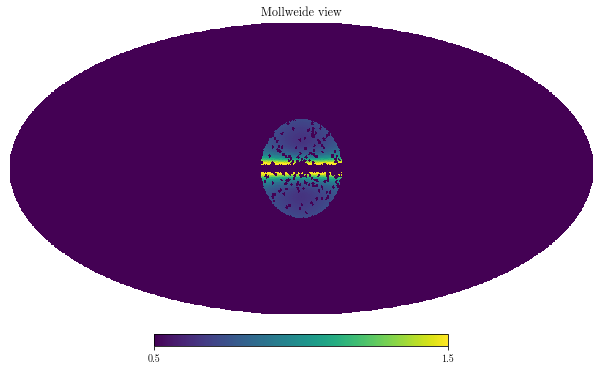

In [12]:
temp_dsk_new = hp.ud_grade(np.load('../data/external/template_disk_r_s_5_z_s_0.3.npy'), nside_out=128, power=-2)
temp_dsk_old = hp.ud_grade(np.load('../data/external/template_disk_r_s_5_z_s_1.npy'), nside_out=128, power=-2)
hp.mollview(~roi_mask * (temp_dsk_new / temp_dsk_old), max=1.5, min=0.5)

In [122]:
n_samples = 5

In [123]:
def save_files(data_map, aux, theta, sample_name):
    np.save("../data/samples/x_{}.npy".format(sample_name), data_map)
    np.save("../data/samples/x_aux_{}.npy".format(sample_name), aux)
    np.save("../data/samples/theta_{}.npy".format(sample_name), theta)

In [124]:
# 0.9286,  0.4314,  0.8864,  0.7524,  7.8482,  3.7519

## Model O

### PS only

In [44]:
# iso, bub, psc, dif
prior_poiss = [[0.4314,  0.8864,  0.7524,  7.8482,  3.7519], [0.4314,  0.8864,  0.7524,  7.8482,  3.7519]]

# gce, dsk
prior_ps = [[1.4, 14.8947, 1.5803, -3.5917, 11.3354,  2.3185,  0.8937, 15.0699,  1.5606, -3.9558, 15.7457,  2.8055], 
            [1.4, 14.8947, 1.5803, -3.5917, 11.3354,  2.3185,  0.8937, 15.0699,  1.5606, -3.9558, 15.7457,  2.8055]]

prior = utils.BoxUniform(low=torch.tensor([0.0] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([0.000] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((n_samples,))

temps_poiss_sim = [temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]
temps_ps_sim = [temp_gce, temp_dsk]

maps = [simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func, fermi_exp) for theta in tqdm_notebook(thetas)]

data_map = torch.Tensor(list(map(itemgetter(0), maps)))
aux = torch.Tensor(list(map(itemgetter(1), maps)))

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/5 [00:00<?, ?it/s]

In [45]:
save_files(data_map, aux, thetas, "ModelO_PS_only")

### DM only

In [125]:
# iso, bub, psc, dif
prior_poiss = [[0.4314,  0.8864,  0.7524,  7.8482,  3.7519], [0.4314,  0.8864,  0.7524,  7.8482,  3.7519]]

# gce, dsk
prior_ps = [[0.001, 14.8947, 1.5803, -3.5917, 11.3354,  2.3185,  0.8937, 15.0699,  1.5606, -3.9558, 15.7457,  2.8055], 
            [0.001, 14.8947, 1.5803, -3.5917, 11.3354,  2.3185,  0.8937, 15.0699,  1.5606, -3.9558, 15.7457,  2.8055]]

prior = utils.BoxUniform(low=torch.tensor([1.4] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([1.4] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((n_samples,))

temps_poiss_sim = [temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]
temps_ps_sim = [temp_gce, temp_dsk]

maps = [simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func, fermi_exp) for theta in tqdm_notebook(thetas)]

data_map = torch.Tensor(list(map(itemgetter(0), maps)))
aux = torch.Tensor(list(map(itemgetter(1), maps)))

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/5 [00:00<?, ?it/s]

In [126]:
save_files(data_map, aux, thetas, "ModelO_DM_only")

## Thick disk

In [127]:
# iso, bub, psc, dif
prior_poiss = [[0.4314,  0.8864,  0.7524,  7.8482,  3.7519], [0.4314,  0.8864,  0.7524,  7.8482,  3.7519]]

# gce, dsk
prior_ps = [[0.001, 14.8947, 1.5803, -3.5917, 11.3354,  2.3185,  0.8937, 15.0699,  1.5606, -3.9558, 15.7457,  2.8055], 
            [0.001, 14.8947, 1.5803, -3.5917, 11.3354,  2.3185,  0.8937, 15.0699,  1.5606, -3.9558, 15.7457,  2.8055]]

prior = utils.BoxUniform(low=torch.tensor([1.4] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([1.4] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((n_samples,))

temps_poiss_sim = [temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]
temps_ps_sim = [temp_gce, temp_dsk_thk]

maps = [simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func, fermi_exp) for theta in tqdm_notebook(thetas)]

data_map = torch.Tensor(list(map(itemgetter(0), maps)))
aux = torch.Tensor(list(map(itemgetter(1), maps)))

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/5 [00:00<?, ?it/s]

In [128]:
save_files(data_map, aux, thetas, "ModelO_thick_disk_DM_only")

## Model A

### PS only

In [129]:
# # iso, bub, psc, dif
# prior_poiss = [[0.4314,  0.8864,  0.7524,  7.8482,  3.7519], [0.4314,  0.8864,  0.7524,  7.8482,  3.7519]]

# # gce, dsk
# prior_ps = [[0.8, 15.0733,
#           1.55, -3.5586,  9.0211,  2.4566, 0.3, 15.288367  ,  1.6130469 ,
#         -4.5172763 , 12.960373  ,  2.4449606], [0.8, 15.0733,
#           1.55, -3.5586,  9.0211,  2.4566, 0.3, 15.288367  ,  1.6130469 ,
#         -4.5172763 , 12.960373  ,  2.4449606]]

# prior = utils.BoxUniform(low=torch.tensor([0.4] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([0.4] + prior_poiss[1] + prior_ps[1]))

# thetas = prior.sample((n_samples,))

# temps_poiss_sim = [temp_gce, temp_iso, temp_bub, temp_psc, temp_mF_pibrem, temp_mF_ics]
# temps_ps_sim = [temp_gce, temp_dsk]

# maps = [simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func, fermi_exp) for theta in tqdm_notebook(thetas)]

# data_map = torch.Tensor(list(map(itemgetter(0), maps)))
# aux = torch.Tensor(list(map(itemgetter(1), maps)))

In [130]:
# save_files(data_map, aux, thetas, "ModelA_PS_only")

### DM only

In [131]:
# iso, bub, psc, dif
prior_poiss = [[0.4314,  0.8864,  0.7524,  7.8482,  3.7519], [0.4314,  0.8864,  0.7524,  7.8482,  3.7519]]

# gce, dsk
prior_ps = [[0.001, 14.8947, 1.5803, -3.5917, 11.3354,  2.3185,  0.8937, 15.0699,  1.5606, -3.9558, 15.7457,  2.8055], 
            [0.001, 14.8947, 1.5803, -3.5917, 11.3354,  2.3185,  0.8937, 15.0699,  1.5606, -3.9558, 15.7457,  2.8055]]

prior = utils.BoxUniform(low=torch.tensor([1.4] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([1.4] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((n_samples,))

temps_poiss_sim = [temp_gce, temp_iso, temp_bub, temp_psc, temp_mA_pibrem, temp_mA_ics]
temps_ps_sim = [temp_gce, temp_dsk]

maps = [simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func, fermi_exp) for theta in tqdm_notebook(thetas)]

data_map = torch.Tensor(list(map(itemgetter(0), maps)))
aux = torch.Tensor(list(map(itemgetter(1), maps)))

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/5 [00:00<?, ?it/s]

In [132]:
save_files(data_map, aux, thetas, "ModelA_DM_only")

## Mismodeling

In [231]:
import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [210]:
nside = 128

mO_mismo = np.load("../../fermi-gce-gp/data/mO_mismo_samples.npy") 
mO_mismo /= np.expand_dims(np.mean(mO_mismo, axis=1), 1)
mismo_func = np.zeros((mO_mismo.shape[0], hp.nside2npix(nside)))
mismo_func[:, ~roi_mask] = mO_mismo

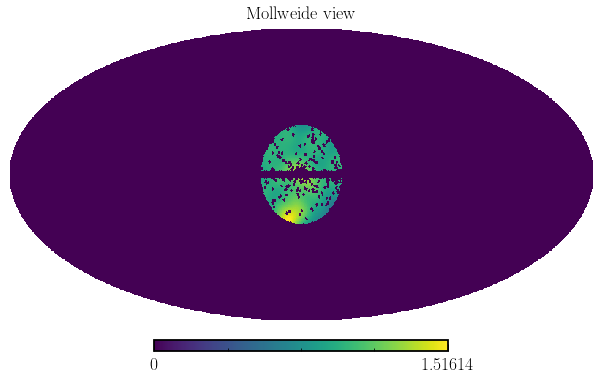

In [211]:
hp.mollview(~roi_mask * mismo_func[330])

In [228]:
# iso, bub, psc, dif
prior_poiss = [[0.4314,  0.8864,  0.7524,  7.8482,  3.7519], [0.4314,  0.8864,  0.7524,  7.8482,  3.7519]]

# gce, dsk
prior_ps = [[0.001, 14.8947, 1.5803, -3.5917, 11.3354,  2.3185,  0.8937, 15.0699,  1.5606, -3.9558, 15.7457,  2.8055], 
            [0.001, 14.8947, 1.5803, -3.5917, 11.3354,  2.3185,  0.8937, 15.0699,  1.5606, -3.9558, 15.7457,  2.8055]]

prior = utils.BoxUniform(low=torch.tensor([1.] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([1.] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((n_samples,))

maps = []
for i, theta in enumerate(thetas):
    temps_poiss_sim = [temp_gce, temp_iso, temp_bub, temp_psc, mismo_func[i] * temp_mO_pibrem, temp_mO_ics]
    temps_ps_sim = [temp_gce, temp_dsk]
    maps.append(simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func, fermi_exp))

data_map = torch.Tensor(list(map(itemgetter(0), maps)))
aux = torch.Tensor(list(map(itemgetter(1), maps)))

In [229]:
save_files(data_map, aux, thetas, "ModelO_DM_only_mismo")

In [241]:
from pylab import arange, show, cm

cmap = cm.RdBu_r
cmap.set_under('w')
cmap.set_bad('w')

rpm = []
for i in range(5):
    m = hp.ma(mismo_func[i])
    m.mask = roi_mask

    rpm.append(hp.cartview(m, min=0.5, max=1.5, lonra=[-25, 25], latra=[-25, 25], return_projected_map=True, cmap=cmap, title="Data-driven mismodeling"));
    rpm[i].mask = (rpm[i].data == 0)
    plt.close()

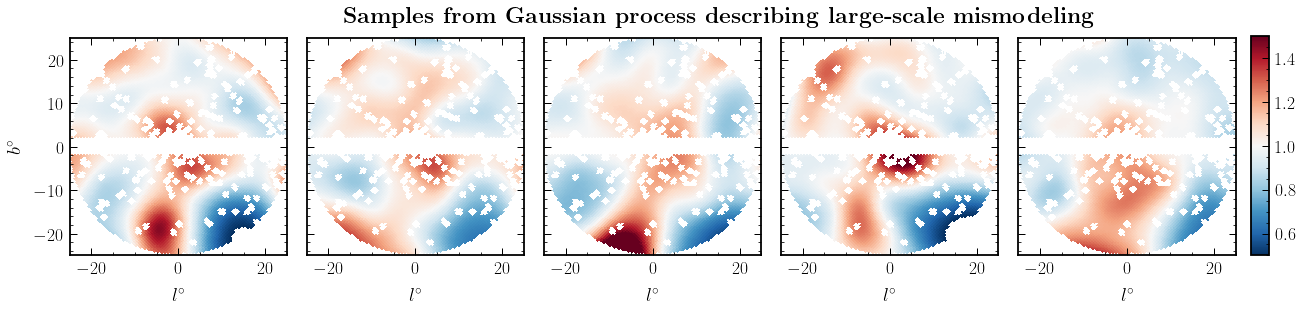

In [360]:
fig, ax = plt.subplots(1, 5, figsize=(25, 4), sharey=True)

for i in range(5):
    im = ax[i].imshow(rpm[i], cmap=cmap, origin='lower', vmin=0.5, vmax=1.5, extent=[-25, 25, -25, 25],)
    ax[i].set_xlabel("$l^\circ$")
    if i == 0:
        ax[i].set_ylabel("$b^\circ$")

fig.subplots_adjust(right=0.8, wspace=-0.11)
cbar_ax = fig.add_axes([0.795, 0.125, 0.01, 0.763])
fig.colorbar(im, cax=cbar_ax)

fig.suptitle(r"\bf{Samples from Gaussian process describing large-scale mismodeling}", fontsize=23, y=0.99)

plt.savefig("../paper/plots/dd_mismo_map.pdf", bbox_inches='tight')

## Asymmetric DM

In [149]:
roi_mask_N = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=0, b_mask=True, b_deg_min=0, mask_ring=True, inner=0, outer=r_outer)
roi_mask_S = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=0, b_mask=True, b_deg_max=0, mask_ring=True, inner=0, outer=r_outer)

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colorm

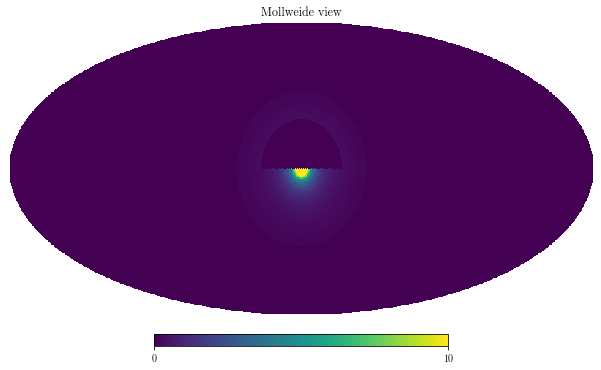

In [150]:
hp.mollview(temp_gce * roi_mask_N, max=10)

In [153]:
# iso, bub, psc, dif
prior_poiss = [[0.4314,  0.8864,  0.7524,  7.8482,  3.7519], [0.4314,  0.8864,  0.7524,  7.8482,  3.7519]]

# gce, dsk
prior_ps = [[0.001, 14.8947, 1.5803, -3.5917, 11.3354,  2.3185,  0.8937, 15.0699,  1.5606, -3.9558, 15.7457,  2.8055], 
            [0.001, 14.8947, 1.5803, -3.5917, 11.3354,  2.3185,  0.8937, 15.0699,  1.5606, -3.9558, 15.7457,  2.8055]]

prior = utils.BoxUniform(low=torch.tensor([2 * 1.2 / 3, 4 * 1.2 / 3] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([2 * 1.2 / 3, 4 * 1.2 / 3] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((n_samples,))

temps_poiss_sim = [temp_gce * roi_mask_N, temp_gce * roi_mask_S, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]
temps_ps_sim = [temp_gce, temp_dsk]

maps = [simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func, fermi_exp) for theta in tqdm_notebook(thetas)]

data_map = torch.Tensor(list(map(itemgetter(0), maps)))
aux = torch.Tensor(list(map(itemgetter(1), maps)))

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/5 [00:00<?, ?it/s]

In [154]:
save_files(data_map, aux, thetas, "ModelO_DM_asym")